
Analyzing AAPL:


/var/folders/5d/xhsfjb553f53b3x4bdkpn6qh0000gn/T/ipykernel_1680/2337975366.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/var/folders/5d/xhsfjb553f53b3x4bdkpn6qh0000gn/T/ipykernel_1680/2337975366.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/var/folders/5d/xhsfjb553f53b3x4bdkpn6qh0000gn/T/ipykernel_1680/2337975366.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_ret = stock.resample('M').last().pct_change()


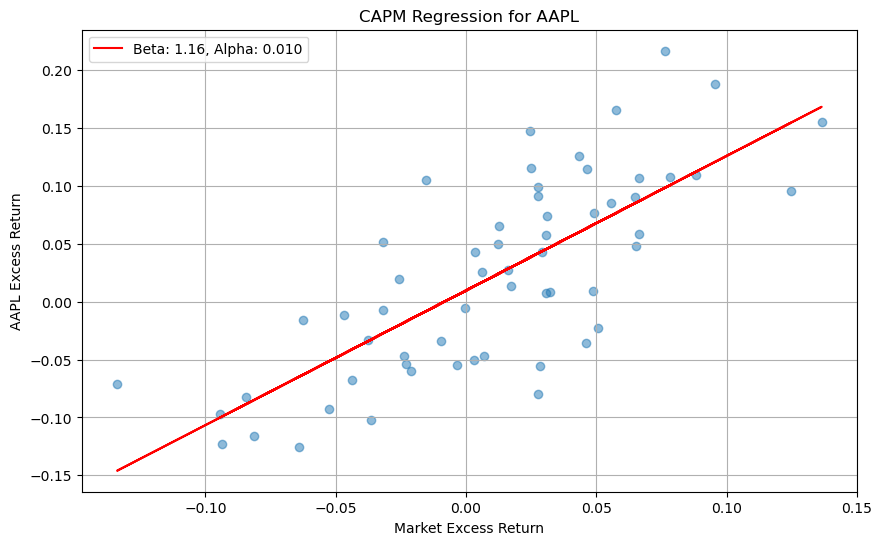

/var/folders/5d/xhsfjb553f53b3x4bdkpn6qh0000gn/T/ipykernel_1680/2337975366.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/var/folders/5d/xhsfjb553f53b3x4bdkpn6qh0000gn/T/ipykernel_1680/2337975366.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100


beta: 1.161
alpha: 0.010
r_squared: 0.572
p_value: 0.000
std_err: 0.133

Analyzing MSFT:


/var/folders/5d/xhsfjb553f53b3x4bdkpn6qh0000gn/T/ipykernel_1680/2337975366.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_ret = stock.resample('M').last().pct_change()


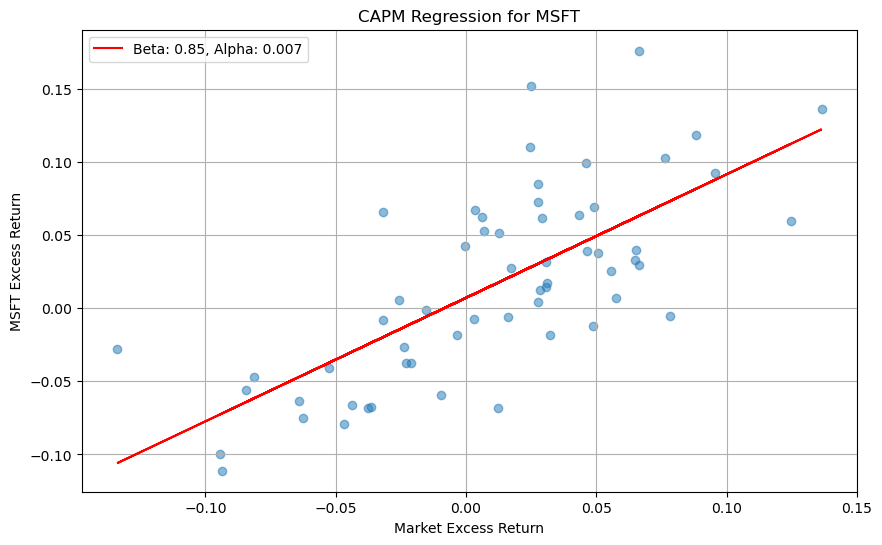

/var/folders/5d/xhsfjb553f53b3x4bdkpn6qh0000gn/T/ipykernel_1680/2337975366.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
/var/folders/5d/xhsfjb553f53b3x4bdkpn6qh0000gn/T/ipykernel_1680/2337975366.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100


beta: 0.845
alpha: 0.007
r_squared: 0.514
p_value: 0.000
std_err: 0.109

Analyzing GE:


/var/folders/5d/xhsfjb553f53b3x4bdkpn6qh0000gn/T/ipykernel_1680/2337975366.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  stock_ret = stock.resample('M').last().pct_change()


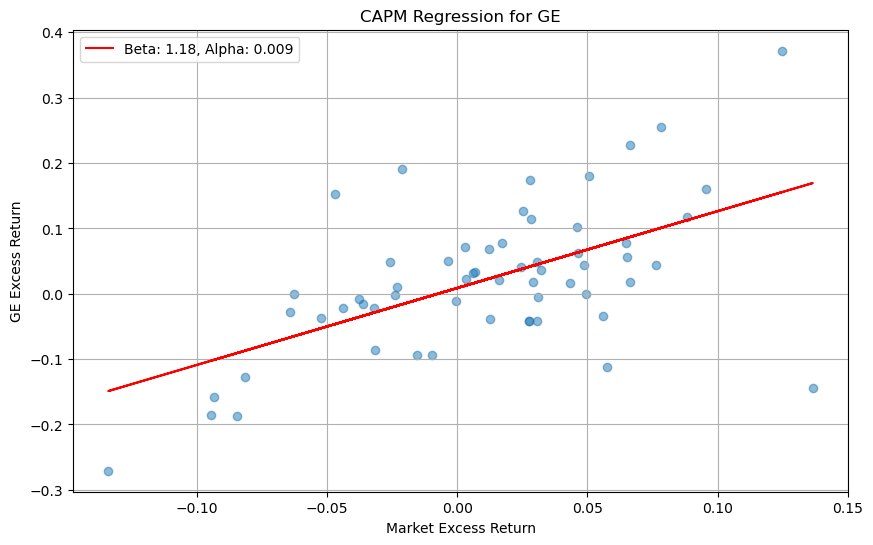

beta: 1.177
alpha: 0.009
r_squared: 0.333
p_value: 0.000
std_err: 0.221


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pandas_datareader import DataReader as pdr


def estimate_beta(ticker, start_date='2020-01-01'):
    """
    Estimates beta for a given stock using monthly returns.
    """
    # Get Fama-French Data (monthly factors) and convert its index to Timestamps.
    ff = pdr('F-F_Research_Data_Factors', 'famafrench', start=1970)[0] / 100
    # Convert the index to Timestamps (we assume these represent month-end dates)
    ff.index = ff.index.to_timestamp('M')
    ff = ff.loc[start_date:]

    # Get stock data and compute monthly returns.
    stock = yf.download(ticker, start=start_date, progress=False)['Close']
    stock_ret = stock.resample('ME').last().pct_change()
    # Convert the Series into a DataFrame so its name ("ret") is kept as a column
    stock_ret = stock_ret[ticker].to_frame(name="ret")
    # Convert its index to Timestamps (month-end) as well
    # Combine the data on the timestamp index.
    df = ff.join(stock_ret, how="inner")

    # Drop any observations that are NaN.
    df = df.dropna()

    # Compute excess returns (subtract risk-free rate).
    df["ret"] = df["ret"] - df["RF"]

    # Run regression: regress stock excess returns on market excess returns.
    beta, alpha, r_value, p_value, std_err = stats.linregress(
        df['Mkt-RF'], df['ret'])

    # Create the regression plot.
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Mkt-RF'], df['ret'], alpha=0.5)
    plt.plot(df['Mkt-RF'], alpha + beta * df['Mkt-RF'], color='red',
             label=f'Beta: {beta:.2f}, Alpha: {alpha:.3f}')
    plt.xlabel('Market Excess Return')
    plt.ylabel(f'{ticker} Excess Return')
    plt.title(f'CAPM Regression for {ticker}')
    plt.legend()
    plt.grid(True)

    return {
        'beta': beta,
        'alpha': alpha,
        'r_squared': r_value**2,
        'p_value': p_value,
        'std_err': std_err
    }


# Example usage:
tickers = ['AAPL', 'MSFT', 'GE']
results = {}
for ticker in tickers:
    print(f"\nAnalyzing {ticker}:")
    results[ticker] = estimate_beta(ticker)
    plt.show()
    for key, value in results[ticker].items():
        print(f"{key}: {value:.3f}")